In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lpmn
import fluid_module as fd

In [3]:
def field_polar_lab(r, theta, phi, B_11, B_tilde_11, B_01):
    """
    r: afstand fra centrum af squirmer
    theta, phi: polar vinkler. phi=pi/2 hvis ser på y og z akse som vi har gjort indtil videre
    
    B_11, B_tilde_11, B_01: Tal mellem -1 og 1. IKKE en matrix men et ENKEL tal. ET tal IKKE Matrix
    
    return hastighed i polare koordinater i LAB frame
    """
    u_r = 4 / (3 * r ** 3) * (B_11 * np.sin(theta) * np.cos(phi) + B_tilde_11 * np.sin(theta) * np.sin(phi) - B_01 * np.cos(theta))
    u_theta = - 2 / (3 * r ** 3) * (B_11 * np.cos(theta) * np.cos(phi) + B_tilde_11 * np.cos(theta) * np.sin(phi) - B_01 * np.sin(theta))
    u_phi = 2 / (3 * r ** 3) * (B_11 * np.sin(phi) - B_tilde_11 * np.cos(phi))
    return u_r, u_theta, u_phi


def field_cartesian_squirmer(r, theta, phi, a, B_11, B_tilde_11, B_01):
    """
    r: afstand fra centrum af squirmer
    theta, phi: polar vinkler. phi=pi/2 hvis ser på y og z akse som vi har gjort indtil videre
    
    LÆG MÆRKE TIL at denne funktion tager én yderligere parameter som er a:
    a: radius af squirmer.
    
    B_11, B_tilde_11, B_01: Tal mellem -1 og 1. IKKE en matrix men et ENKEL tal. ET tal IKKE Matrix
    
    returner hastighed i kartetiske koordinater i SQUIRMER frame
    """
    u_r, u_theta, u_phi = field_polar_lab(r, theta, phi, B_11, B_tilde_11, B_01)
    
    u_z = np.cos(theta) * u_r - np.sin(theta) * u_theta
    u_y = u_r * np.sin(theta) * np.sin(phi) + u_theta * np.cos(theta) * np.sin(phi) + u_phi * np.cos(phi)
    u_x = u_r * np.sin(theta) * np.cos(phi) + u_theta * np.cos(theta) * np.cos(phi) - u_phi * np.sin(phi)
    
    u_z += B_01 * 4 / (3 * a ** 3)
    u_y += -B_tilde_11 * 4 / (3 * a ** 3)
    u_x += -B_11 * 4 / (3 * a ** 3)
    return u_x, u_y, u_z
    

In [4]:
def field_polar_lab_updated(N, r, theta, a, B, B_tilde, C, C_tilde):
    """Calculate the field in polar coordinates

    Args:
        N (int larger than 1): Max possible mode
        r (float): Distance between target and agent (prey and squirmer)
        theta (float): Angle between vertical axis z and target
        a (float): Squirmer radius
        B ((N+1, N+1)-array): Modes
        B_tilde ((N+1, N+1)-array): Modes
        C ((N+1, N+1)-array)): Modes
        C_tilde ((N+1, N+1)-array): Modes

    Returns:
        u_r (float): 
            Velocity in the radial direction
        u_theta (float):
            Angular velocity        
    """
    phi = np.pi / 2
    LP, LP_deriv = lpmn(N, N, np.cos(theta))
    r_first_term = 4 / (3 * r ** 3) * (B[1, 1] * np.sin(theta) * np.cos(phi) 
                                       + B_tilde[1, 1] * np.sin(theta) * np.sin(phi) 
                                       - B[0, 1] * np.cos(theta))
    theta_first_term = - 2 / (3 * r ** 3) * (B[1, 1] * np.cos(theta) * np.cos(phi)
                                             + B_tilde[1, 1] * np.cos(theta) * np.sin(phi)
                                             + B[0, 1] * np.sin(theta))
    u_r = r_first_term
    u_theta = theta_first_term 
    for n in np.arange(2, N+1):  # Sum starts at n=2 and ends at N
        m_arr = np.arange(n+1)  # Since endpoints are not included, all must +1
        #mask = (slice(n+1), slice(n))
        LP_arr = LP[:n+1, n]
        LP_deriv_arr = LP_deriv[:n+1, n]
        B_arr = B[:n+1, n]
        B_tilde_arr = B_tilde[:n+1, n]
        C_arr = C[:n+1, n]
        C_tilde_arr = C_tilde[:n+1, n]
        # Array with velocities for each m can be summed to give the total value of the inner sum.
        u_r_arr = ((n + 1) * LP_arr / r ** (n + 2)
                   * ((r / a) ** 2 - 1)
                   * (B_arr * np.cos(m_arr * phi) + B_tilde_arr * np.sin(m_arr * phi)) 
        )
        
        
        u_theta_arr = (np.sin(theta) * LP_deriv_arr
                   * ((n - 2) / (n * a ** 2 * r ** n) - 1 / r ** (n + 2))
                   * (B_arr * np.cos(m_arr * phi) + B_tilde_arr * np.sin(m_arr * phi))
                   + m_arr * LP_arr / (r ** (n + 1) * np.sin(theta)) 
                   * (C_tilde_arr * np.cos(m_arr * phi) - C_arr * np.sin(m_arr * phi))
        )
        
        u_r += np.sum(u_r_arr)
        u_theta += np.sum(u_theta_arr)
     
    return u_r, u_theta
    
def field_polar(N, r, theta, a, B, B_tilde, C, C_tilde):
    """Calculate the field in polar coordinates

    Args:
        N (int larger than 1): Max possible mode
        r (float): Distance between target and agent (prey and squirmer)
        theta (float): Angle between vertical axis z and target
        a (float): Squirmer radius
        B ((N+1, N+1)-array): Modes
        B_tilde ((N+1, N+1)-array): Modes
        C ((N+1, N+1)-array)): Modes
        C_tilde ((N+1, N+1)-array): Modes

    Returns:
        u_r (float): 
            Velocity in the radial direction
        u_theta (float):
            Angular velocity        
    """
    phi = np.pi / 2
    LP, LP_deriv = lpmn(N, N, np.cos(theta))
    r_first_term = 4 / (3 * r ** 3) * (B[1, 1] * np.sin(theta) * np.cos(phi) 
                                       + B_tilde[1, 1] * np.sin(theta) * np.sin(phi) 
                                       - B[0, 1] * np.cos(theta))
    theta_first_term = - 2 / (3 * r ** 3) * (B[1, 1] * np.cos(theta) * np.cos(phi)
                                             + B_tilde[1, 1] * np.cos(theta) * np.sin(phi)
                                             + B[0, 1] * np.sin(theta))
    u_r = r_first_term
    u_theta = theta_first_term 
    for n in np.arange(2, N+1):  # Sum starts at n=2 and ends at N
        m_arr = np.arange(n+1)  # Since endpoints are not included, all must +1
        #mask = (slice(n+1), slice(n))
        LP_arr = LP[:n+1, n]
        LP_deriv_arr = LP_deriv[:n+1, n]
        B_arr = B[:n+1, n]
        B_tilde_arr = B_tilde[:n+1, n]
        C_arr = C[:n+1, n]
        C_tilde_arr = C_tilde[:n+1, n]
        # Array with velocities for each m can be summed to give the total value of the inner sum.
        u_r_arr = ((n + 1) * LP_arr / r ** (n + 2)
                   * ((r / a) ** 2 - 1)
                   * (B_arr * np.cos(m_arr * phi) + B_tilde_arr * np.sin(m_arr * phi)) 
        )
        
        u_theta_arr = (np.sin(theta) * LP_deriv_arr
                   * ((n - 2) / (n * a ** 2 * r ** n) - 1 / r ** (n + 2))
                   * (B_arr * np.cos(m_arr * phi) + B_tilde_arr * np.sin(m_arr * phi))
                   + m_arr * LP_arr / (r ** (n + 1) * np.sin(theta)) 
                   * (C_tilde_arr * np.cos(m_arr * phi) - C_arr * np.sin(m_arr * phi))
        )
        u_r += np.sum(u_r_arr)
        u_theta += np.sum(u_theta_arr)
     
    return u_r, u_theta
    

def field_cartesian(N, r, theta, a, B, B_tilde, C, C_tilde, lab_frame=True):
    """Convert polar velocities to cartesian
    
    Args:
        N (int larger than 1): Max possible mode
        r (float): Distance between target and agent (prey and squirmer)
        theta (float): Angle between vertical axis z and target
        a (float): Squirmer radius
        B ((N+1, N+1)-array): Modes
        B_tilde ((N+1, N+1)-array): Modes
        C ((N+1, N+1)-array)): Modes
        C_tilde ((N+1, N+1)-array): Modes
        lab_frame (Bool): If chooses lab or squirmer frame

    Returns:
        u_r (float): 
            Velocity in the radial direction
        u_theta (float):
            Angular velocity        
    """
    phi = np.pi / 2
    u_phi = 0
    u_r, u_theta = field_polar(N, r, theta, a, B, B_tilde, C, C_tilde)
    
    u_z = np.cos(theta) * u_r - np.sin(theta) * u_theta
    u_y = u_r * np.sin(theta) * np.sin(phi) + u_theta * np.cos(theta) * np.sin(phi) + u_phi * np.cos(phi)
    
    
    if not lab_frame:  # Convert to squirmer frame
        u_z += B[0, 1] * 4 / (3 * a ** 3) + np.sin(theta) * r / a ** 3 * C[1, 1]
        u_y += -B_tilde[1, 1] * 4 / (3 * a ** 3) - np.cos(theta) * r / a ** 3 * C[1, 1]
        
    
    else:
        u_z += - np.sin(theta) * r / a ** 3 * C[1, 1]
        u_y +=  np.cos(theta) * r / a ** 3 * C[1, 1]
        
    return u_y, u_z


In [16]:
a=1
z = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
Z, Y = np.meshgrid(z, y)
R = np.sqrt(Z**2 + Y**2)
Theta = np.arctan2(Y,Z) + np.pi
Phi = np.ones(np.shape(Theta)) * np.pi/2


u_x, u_y, u_z = field_cartesian_squirmer(R, Theta, Phi, a, 0, -1, 0)

# Updated function
u_y_upd = np.empty((len(y), len(z)))
u_z_upd = np.empty_like(u_y_upd)
B = np.zeros((4,4))
B_tilde = np.zeros((4,4))
C_tilde = np.zeros((4,4))
C = np.zeros((4,4))
B[0, 1] = 1
#C[1,1] = -0.1
theta_list=[]
for i, y_val in enumerate(y):
    for j, z_val in enumerate(z):
        theta = np.arctan2(y_val, z_val) + np.pi
        u_y_upd_val, u_z_upd_val = field_cartesian(N=3, r=np.sqrt(y_val**2 + z_val**2), theta=theta, a=a, 
                                                 B=B,
                                                 B_tilde=B_tilde,
                                                 C=C,
                                                 C_tilde=C_tilde, lab_frame=True)
        theta_list.append(theta)
        u_y_upd[i, j] = u_y_upd_val
        u_z_upd[i, j] = u_z_upd_val
        

u_x[R<a]=0
u_y[R<a]=0
u_z[R<a]=0

u_y_upd[R<a]=0
u_z_upd[R<a]=0



Text(0.5, 1.0, 'Mode ')

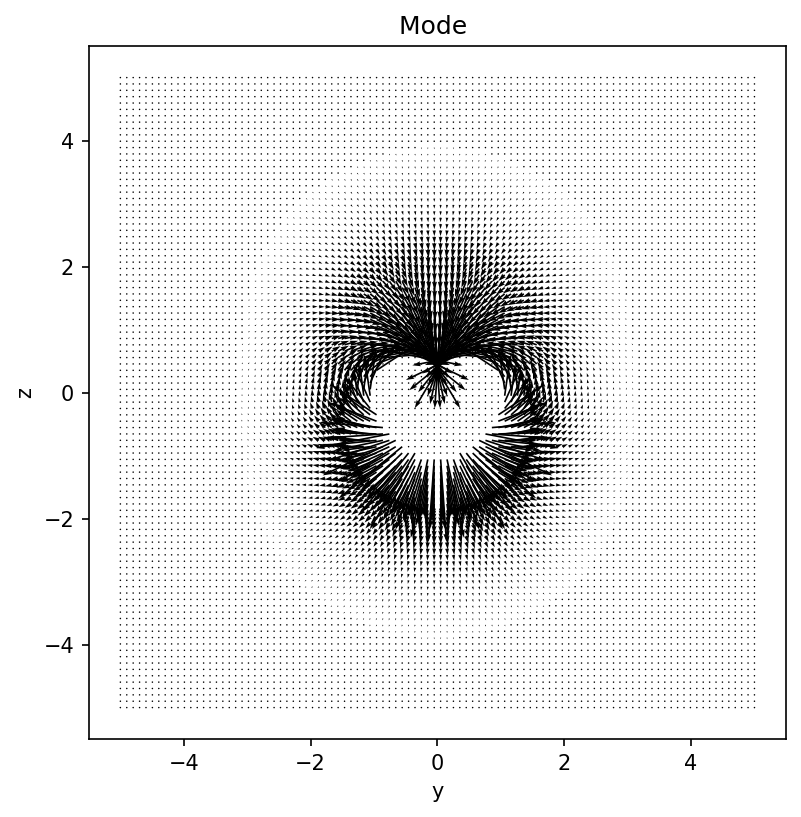

In [18]:
circle1 = plt.Circle((0, 0), 1, color='r')

fig1, ax1 = plt.subplots(figsize=(6, 6),dpi=150)
#ax1.set_xlim([-3, 3])
#ax1.set_ylim([-3, 3])

plt.quiver(Y, Z, u_y_upd, u_z_upd )
#ax1.streamplot(Z, Y, u_z_upd, u_y_upd, density = 2)


#ax1.add_patch(circle1)

plt.xlabel("y")
plt.ylabel("z")
plt.title("Mode ")

Text(0.5, 1.0, 'Mode ')

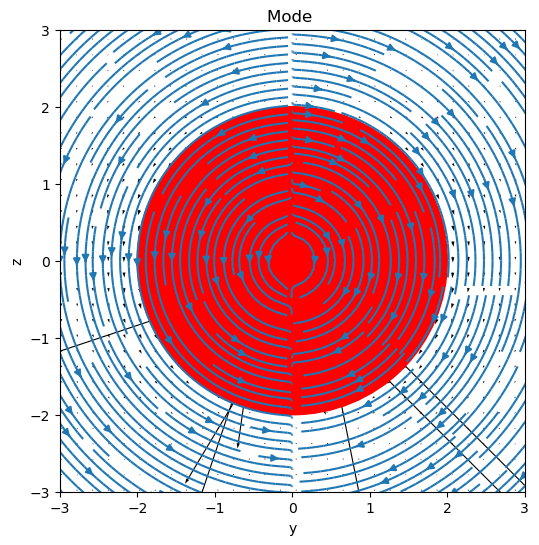

In [235]:
circle1 = plt.Circle((0, 0), 2, color='r')

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])


u_r =0
u_t = -3*np.cos(Theta)/(R**2 )



u_z =np.cos(Theta) * u_r - np.sin(Theta) * u_t 
u_y = u_r*np.sin(Theta) + u_t*np.cos(Theta)


skip = (slice(None, None, 2), slice(None, None, 2))
plt.quiver(Z[skip], Y[skip], u_z[skip], u_y[skip], )
ax.streamplot(Z[skip], Y[skip], u_z[skip], u_y[skip], density = 3)


ax.add_patch(circle1)

plt.xlabel("y")
plt.ylabel("z")
plt.title("Mode ")

In [161]:
print(np.max(Theta ), np.min(Theta ))

6.273084640594265 0.010100666585321605
